# Project 3: Part 1 - Missing 7

The objective of this project is to examine how a deep learning model performs on unseen data. Therefore, we will train a model based on data from the MNIST database, which consists of images of handwritten digits ranging from 0 to 9. To analyze the effect of unseen data, we plan to omit the number 7 from the training set. Later, we will let the model make predictions for images that contain the digit 7.

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## The data

In [11]:
data = np.loadtxt(open('/home/marvin/Downloads/mnist_train_small.csv','rb'),delimiter=',')

# Seperate all labels with seven from rest of the data
data_with7s = data[data[:,0]==7]
data_no7s = data[data[:,0]!=7]

### extract labels (number IDs) and remove from data

# Seperate the sevens again
labels_with7s = data_with7s[:,0]
data_with7s = data_with7s[:,1:]

# Seperate the non-sevens again
labels_no7s = data_no7s[:,0]
data_no7s = data_no7s[:,1:]


### normalize the data to a range of 0 to 1

# Seperate the sevens again
data_with7sNorm = data_with7s/np.max(data_with7s)

# Seperate the non-sevens again
data_no7sNorm = data_no7s/np.max(data_no7s)

In [12]:
# Create train/test groups using DataLoader

### Step 1: Covert to tensors 

# For the sevens
data_with7sT = torch.tensor(data_with7sNorm).float()
labels_with7sT = torch.tensor(labels_with7s).long()

# For the non-sevens
data_no7sT = torch.tensor(data_no7sNorm).float()
labels_no7sT = torch.tensor(labels_no7s).long()

### Step 2: Use sklearn to split the data

# For the sevens
train_data_with7s, test_data_with7s, train_labels_with7s, test_labels_with7s = train_test_split(data_with7sT, labels_with7sT, test_size=0.1 )

# For the non-sevens
train_data_no7s, test_data_no7s, train_labels_no7s, test_labels_no7s = train_test_split(data_no7sT,labels_no7sT, test_size=0.1)

### Step 3: Convert them into Ptytorch datasets

# For the sevens
train_data_with7s = TensorDataset(train_data_with7s,train_labels_with7s)

test_data_with7s = TensorDataset(test_data_with7s, test_labels_with7s)

# For the non-sevens
train_data_no7s = TensorDataset(train_data_no7s, train_labels_no7s)

test_data_no7s = TensorDataset(test_data_no7s, test_labels_no7s)

### Step 4: Convert them into dataloader objects

batchsize= 32

# For the sevens
train_loader_with7s = DataLoader(train_data_with7s, batch_size=batchsize, shuffle=True, drop_last=True)

test_loader_with7s = DataLoader(test_data_with7s, batch_size=test_data_with7s.tensors[0].shape[0])

# For the non-sevens
train_loader_no7s = DataLoader(train_data_no7s, batch_size=batchsize, shuffle=True, drop_last=True)

test_loader_no7s = DataLoader(test_data_no7s, batch_size=test_data_no7s.tensors[0].shape[0])

## Create the model

In [13]:
def createthemodel():

    class TheModel(nn.Module):
        def __init__(self):
            super().__init__()
        
            ### layers
        
            # input laqyer
            self.input = nn.Linear(784,64)
        
            # hidden layer
            self.fc1 = nn.Linear(64,64)
            self.fc2 = nn.Linear(64,32)
        
            # output layer
            self.output = nn.Linear(32,10)
    
        # forward pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)

            return x

    # create a model instace
    net = TheModel()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer


## Train the model

In [14]:
def trainTheModel(train_loader,test_loader):
    numeopchs = 50
    
    # create a new model
    net, lossfun, optimizer = createthemodel()
    
    # initialize
    losses = np.zeros(numeopchs)
    trainAcc = []
    testAcc = []
    
    # loop over epochs
    for epochi in range(numeopchs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        
        for X,y in train_loader:
            
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)
            
            # back prob
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss from this batch
            batchLoss.append(loss.item())
            
            # compute accuracy
            matches = torch.argmax(yHat, axis=1)==y
            matchesNumeric = matches.float()
            accuracyPtc = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPtc)
         # end batch loop
        
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))
        
        # and get the avarge losses across the batches
        losses[epochi] = np.mean(batchLoss)
     # end epochs
    
    # function output
    return trainAcc, losses, net   

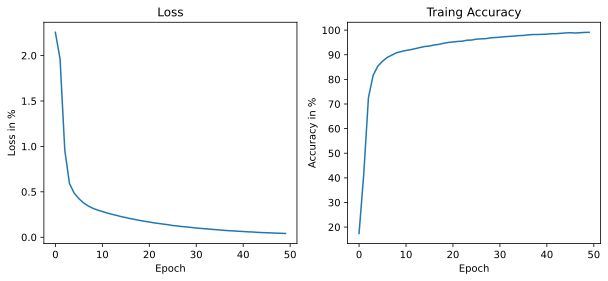

In [16]:
# get the train accuracy, losses and an instnace of the net
trainAcc, losses, net  = trainTheModel(train_loader_no7s ,test_loader_no7s )

# plot the model 
fig, ax = plt.subplots(1,2, figsize=(10,4))

# plot the loss
ax[0].plot(losses)
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss in %')

# plot the training accuracy
ax[1].plot(trainAcc)
ax[1].set_title('Traing Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy in %')


plt.show()

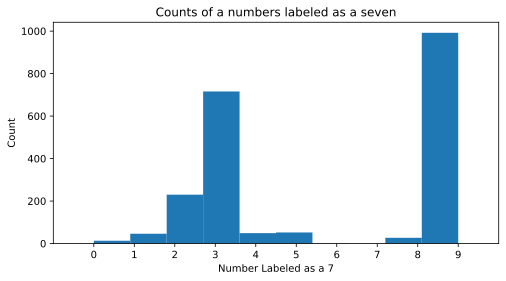

In [17]:
# obtain predictions for images depicting the number seven." 

net.eval()

with torch.no_grad():
    yHat = net(data_with7sT)

predictions_for_sevens = torch.argmax(yHat, axis=1)


# generate a countplot for the above prediction

plt.figure(figsize=(8,4))
plt.hist(predictions_for_sevens)
plt.title('Counts of a numbers labeled as a seven')
plt.xlabel('Number Labeled as a 7')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlim([-1, 10])
plt.ylabel('Count')

plt.show()

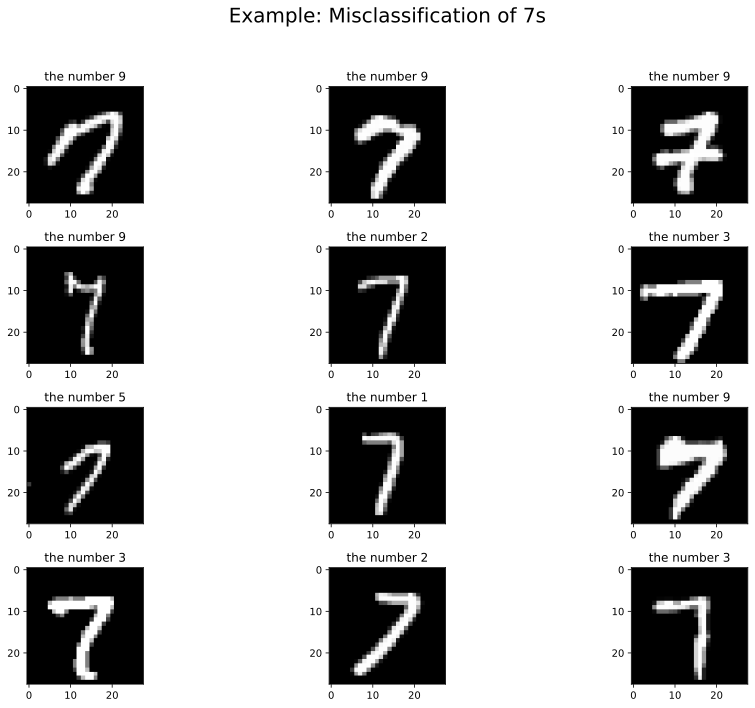

In [18]:
# display the first 12 digits that were falsely predicted as not being sevens.

fig, axs = plt.subplots(4,3, figsize=(14,10))

for idx, ax in enumerate(axs.flatten()):
    data_with7sT[idx,:]
      
    # to create an image thge data must be reshaped
    img = np.reshape(data_with7sT[idx,:], (28,28))
    ax.imshow(img,cmap='gray')
    
    # set title for each subplot
    ax.set_title('the number %i'%predictions_for_sevens[idx])

plt.suptitle('Example: Misclassification of 7s', fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])    
plt.show()

# Reference

https://www.udemy.com/course/deeplearning_x